In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x166a64615c8>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'station': 'USC00519397',
 'prcp': 0.08}

In [11]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x166a64db588>,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'id': 1,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'elevation': 3.0}

# Exploratory Climate Analysis

Text(0.5, 1.0, 'Precipitation vs. Date')

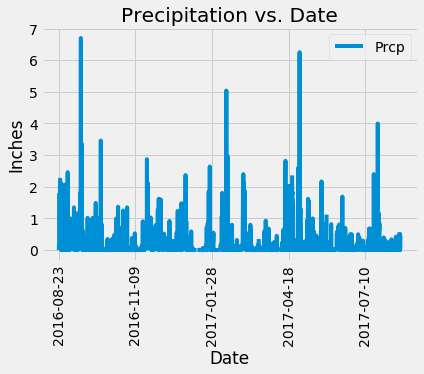

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
max_date = session.query(func.max(Measurement.date)).all()
max_date[0]
max_date[0][0]
m_date = dt.datetime.strptime(max_date[0][0], '%Y-%m-%d')

# Calculate the date 1 year ago from the last data point in the database
min_date = m_date - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.prcp, Measurement.date).\
filter(Measurement.date >= min_date).\
order_by(Measurement.date).all()

# Create a dataframe from the query results and set the index to the date column
result_df = pd.DataFrame(results, columns = ["Prcp", "Date"])
result_df.set_index('Date', inplace = True)
# Sort the dataframe by date
result_df.sort_values("Date")
result_df.plot(rot=90)
plt.ylabel("Inches")
plt.title("Precipitation vs. Date")

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
"""Note: what this means is to use the .plot() method on your dataframe variable,
and then format the labels with methods like plt.xlabel() and plt.title(). 

For example:
df.plot()
plt.xlabels()

As opposed to:
plt.bar()
plt.xlabels()

This is something you would never actually do. If you're importing matplotlib, you'd use
it to generate the plot, as well as the formatting. It's good practice, if you're importing a library,
to use it for everything you can use that library for. Every libarary you causes your program to take up
more memory, so use what you import.
"""

"Note: what this means is to use the .plot() method on your dataframe variable,\nand then format the labels with methods like plt.xlabel() and plt.title(). \n\nFor example:\ndf.plot()\nplt.xlabels()\n\nAs opposed to:\nplt.bar()\nplt.xlabels()\n\nThis is something you would never actually do. If you're importing matplotlib, you'd use\nit to generate the plot, as well as the formatting. It's good practice, if you're importing a library,\nto use it for everything you can use that library for. Every libarary you causes your program to take up\nmore memory, so use what you import.\n"

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
result_df.describe()

,Prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
engine.execute('select * from station').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.round(func.avg(Measurement.tobs))).\
filter(Measurement.station == "USC00519281").all()
stats

[(54.0, 85.0, 72.0)]

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
filter(Measurement.date >= min_date).\
order_by(Measurement.date).all()
 
temp_df = pd.DataFrame(temp, columns = ["Station", "Date", "Temperature"])
temp_df.set_index('Date', inplace = True)
temp_df

,Station,Temperature
Date,,
2016-08-23,USC00519397,81.0
2016-08-23,USC00513117,76.0
2016-08-23,USC00514830,80.0
2016-08-23,USC00517948,80.0
2016-08-23,USC00519523,80.0
...,...,...
2017-08-22,USC00516128,76.0
2017-08-23,USC00519397,81.0
2017-08-23,USC00514830,82.0


In [19]:
temp_count = temp_df['Station'].value_counts()
temp_count

USC00519397    361
USC00519281    352
USC00516128    349
USC00513117    343
USC00519523    337
USC00514830    305
USC00517948    183
Name: Station, dtype: int64

In [20]:
Station = temp_df.loc[temp_df["Station"] == 'USC00519281']
Station

,Station,Temperature
Date,,
2016-08-23,USC00519281,77.0
2016-08-24,USC00519281,77.0
2016-08-25,USC00519281,80.0
2016-08-26,USC00519281,80.0
2016-08-27,USC00519281,75.0
...,...,...
2017-08-14,USC00519281,77.0
2017-08-15,USC00519281,77.0
2017-08-16,USC00519281,76.0


Text(0.5, 1.0, 'Temperature vs. Date')

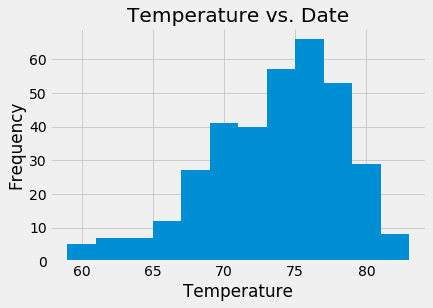

In [21]:
Station.hist(bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Temperature vs. Date")